# Analysis of eating patterns in CALERIE participants

The data analyzed in this notebook comes from Phase II of the [CALERIE study](https://calerie.duke.edu) which examined the effects of caloric restriction on many different health outcomes and biomarkers over two years. In this notebook we cluster participants based on their percentage calorie intake.

It is well established that the quantity and quality of the food we consume can affect our health. Now it is becoming clear that when we eat also plays a key role in health and disease \[[Manoogian et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7213043/)\], which is the reason for this analysis.

If you wish to replicate these analyses yourself, you will need to obtain both the complete Public Use Database and the file foodtime.CSV from the [administrators of the CALERIE study](https://calerie.duke.edu/samples-data-access-and-analysis).  The file foodtime.CSV is not part of the normal Public Use Database distribution, so you will need to request it specifically. It contains the timing of individual meals in the participant's food logs.

# Load data
From a combination of ascii flat files 

In [1]:
import pandas as pd
import seaborn as sns
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.display import display

from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.anova import anova_lm

from pathlib import Path

%matplotlib inline

! pip list



Package                            Version            
---------------------------------- -------------------
alabaster                          0.7.12             
anaconda-client                    1.7.2              
anaconda-navigator                 1.9.12             
anaconda-project                   0.8.3              
appdirs                            1.4.4              
applaunchservices                  0.2.1              
appnope                            0.1.0              
appscript                          1.0.1              
argh                               0.26.2             
asn1crypto                         1.3.0              
astroid                            2.3.3              
astropy                            4.0                
atomicwrites                       1.3.0              
attrs                              19.3.0             
autopep8                           1.4.4              
Babel                              2.8.0              
backcall  

In [2]:
! python --version

Python 3.7.6


In [3]:
path = './analysis_ascii_data/'
files = glob.glob(path+'*.CSV')
dtables = {}
for afile in files:
    fname = afile.split('/')[-1].split('.')[0]
    print(fname)  
    df = pd.read_csv(afile)
    dtables[fname] = df



POMSA
CLWTLONG
SUBJECT1
IVRSRAND
BSQA
HOMEWT
SFLABLNG
TEERESID
FORMATS
SFLABFLT
FCI
TEERQ
CANTABA
WELQA
HEMATOL
PCTCRVIS
PARVISIT
FCQTRTA
PAL
DXAA
DLWLONG
BDI
VO2MAX
CLWTVIS
FCQSTATA
BONELAB
PCTCRST
PSSA
PSQI
PCTCR
CORETMPA
RMRRESID
OCLABFLT
ECGA
FOODWEEK
COGBIAS
DEROGATI
OCLABLNG
RXCAL
BIOPSYA
ISOMETRA
RANDSF36
AE
HANDGRPA
TFEQ
SAE
AREERESD
DTH
RMRA
VISITS
VITALSA
MAEDSA


In [4]:
# these are the people who actually completed the study!!
participants = dtables['SUBJECT1'].query('txcomp=="Completed Intervention"')[['deidnum']].set_index('deidnum').join(dtables['IVRSRAND'].set_index('deidnum'))['tx'].to_frame()
participants.reset_index().groupby('tx').count()

,deidnum
tx,
Caloric Restriction,117
Control,71


In [5]:
foodwk = dtables['FOODWEEK']['kcal'].apply(lambda x: np.NaN if x==' ' else float(x)).to_frame().join( dtables['FOODWEEK'][['deidnum','visit']] ).set_index('deidnum')
foodwk['period']= foodwk.visit.apply(lambda x: 'Baseline' if x[0]=='B' else 'Intervention')
foodwk['year'] = foodwk.visit.apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if int(x[-2:]) <= 12 else 'Year 2')
foodwk = foodwk.join(participants,how='inner')
kcals_period = foodwk.groupby(['deidnum','period'])['kcal'].mean().unstack()
kcals_visit = foodwk.groupby(['deidnum','visit'])['kcal'].mean().unstack()
kcals_year = foodwk.groupby(['deidnum','year'])['kcal'].mean().unstack()

In [6]:
food = pd.read_csv('satchins_data/foodtime.CSV').set_index('deidnum').join(participants,how='inner').reset_index()
dtables['FOOD']=food
ampm = food.mealtime.apply(lambda x: x[-2])

pmoffset = food.mealtime.apply(lambda x: 0 if x[-2]=='A' else 12 if x[-2]=='P' else None )

hrs = food.mealtime.apply(lambda x: int(x[:-3].split(':')[0]))

pmoffset = pmoffset - 12*(  (hrs==12) ) #take care of the 12AM and 12PM garbage

mins = food.mealtime.apply(lambda x: int(x[:-3].split(':')[1] if ':' in x else 0))

ltime = hrs+pmoffset + mins/60.
ltime = ltime.rename('Hour of day')

ltime = ltime + 24 * (ltime<4.0)

meals = ltime.to_frame().join( food.mealtime ).join( food[[ 'intakedt', 'deidnum', 'mealname', 'mealloc', 'KCAL', 'tx', 'visname' ]] )#.join( dtables['IVRSRAND'].set_index('deidnum').tx, on='deidnum')

# these divisions based on where it looks like the breakpoints are in 
# meals.intakedt.hist(bins=np.arange(-200,900,40))
# np.sort( meals.intakedt.unique() )
# but it turns out this isn't accurate for a few dozen entries
# meals['year'] = meals.intakedt.apply( lambda x: 'Baseline' if x<12 else 'Year 1' if x<450 else 'Year 2')
# meals['condition'] = meals.intakedt.apply( lambda x: 'Baseline' if x<12 else 'Intervention' )
# below is better since it's the actually recorded visit name
meals['year'] = meals.visname.apply( lambda x: 'Baseline' if x[0]=='B' else 'Year 1' if (x in ['M6','M12']) else 'Year 2')
meals['condition'] = meals.visname.apply( lambda x: 'Baseline' if x[0]=='B' else 'Intervention')

# some elements seem to get read in as str instead of float, because there is one line with " "
vals = []
labels = []
for k,el in meals.KCAL.iteritems(): 
    if el==' ':
        vals.append( np.nan )
    else:
        vals.append(float(el))
    labels.append(k)
meals.loc[:,'KCAL'] = pd.Series(data=vals,index=labels)
        
dtables['MEALS']=meals




/Users/suijialu/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,114,115,117,118,119,120,121,122,123,124,125,126,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Analyze diet cluster based on calorie intake

In [7]:
food

,deidnum,visname,intakedt,mealtime,mealfile,mealname,mealloc,TGRAMS,KCAL,TFAT,...,CLACIS9,CLATR10,TAGATOSE,VITD2,VITD3,ASUGART,PUFAALA,SOLIDFAT,GLUTEN,tx
0,1057,BL1,-50,10 AM,1,Breakfast,Home,287.900,259.9,7.279,...,0.001,0.001,0,0,0,14.21,0.463,1.064,0,Caloric Restriction
1,1057,BL1,-50,12 PM,2,Lunch,Home,398.000,606.186,17.207,...,0.036,0.006,0,0,0.076,5.442,0.508,7.935,8.589,Caloric Restriction
2,1057,BL1,-50,5:00 PM,3,Dinner/Supper,Home,74.063,236.535,6.098,...,0.007,0.001,0,0,0.005,22.664,0.042,1.582,2.35,Caloric Restriction
3,1057,BL1,-50,9:30 PM,4,Snack,Home,106.200,100.051,3.126,...,0.014,0.002,0,0,0.177,,0.047,2.432,0.269,Caloric Restriction
4,1057,BL1,-49,12 AM,4,Snack,Home,321.849,91.669,1.344,...,0,0.001,0,0,0,0,0.011,0,0,Caloric Restriction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28277,99866,M24,719,12 PM,2,Lunch,Work,402.000,600.484,22.527,...,0.024,0.005,0,0,0.563,0,0.427,1.11,0,Control
28278,99866,M24,719,7:00 PM,3,Dinner/Supper,Home,520.800,1075.21,64.384,...,0.229,0.04,0.3,0,0.981,0,0.657,45.902,0.784,Control
28279,99866,M24,720,7:20 AM,1,Breakfast,Home,56.699,161.053,5.348,...,0.001,0,0,0,0.318,6.344,0.039,2.623,1.618,Control
28280,99866,M24,720,6:00 PM,2,Snack,Work,383.550,154.707,9.992,...,0,0,0,0,0,0,0.009,0,0,Control


In [8]:
food.KCAL = food.KCAL.apply(lambda x: np.NaN if x==' ' else float(x)).dropna()

In [9]:
mean_bl = food.query('visname=="BL1" or visname=="BL2"').groupby(['deidnum','mealname']).KCAL.mean()
mean_bl

deidnum  mealname     
1057     Breakfast        253.009333
         Dinner/Supper    430.185333
         Lunch            318.808833
         Snack            120.862706
1948     Breakfast        384.365000
                             ...    
99413    Snack            146.557273
99866    Breakfast        263.277000
         Dinner/Supper    818.850000
         Lunch            587.707750
         Snack            117.881200
Name: KCAL, Length: 817, dtype: float64

In [10]:
# method to detect miss of meals

def detect_loss(mean_bl):
    standard = ['Breakfast','Dinner/Supper','Lunch','Other','Snack']
    loss_dict = {}
    pre_index  = -1
    current = []
    for ((index,meal),kcal) in mean_bl.iteritems():     
        
        if pre_index == -1:
            pre_index = index
            current.append(meal)
        elif pre_index == index:
            pre_index = index
            current.append(meal)
            
        elif index != pre_index and pre_index != -1:
            if current == standard:
                current = []
                pre_index = -1
                current.append(meal)
            else:
                difference = [x for x in standard if x not in current]
                loss_dict[pre_index] = difference
                current = []
                pre_index=-1
                current.append(meal)
    if current != standard:
        difference = [x for x in standard if x not in current]
        loss_dict[pre_index] = difference

    return loss_dict
            
        
        
        

In [11]:
loss_dict = detect_loss(mean_bl)

In [12]:
loss_dict

{1057: ['Other'],
 2355: ['Other'],
 2373: ['Other'],
 3201: ['Other'],
 5267: ['Other'],
 6827: ['Other'],
 6909: ['Other'],
 8211: ['Other'],
 9362: ['Other'],
 10043: ['Other'],
 12195: ['Other'],
 12536: ['Other'],
 13205: ['Other', 'Snack'],
 13837: ['Other'],
 17123: ['Other'],
 18964: ['Other'],
 19056: ['Other'],
 19317: ['Other'],
 19337: ['Other'],
 19553: ['Other'],
 19809: ['Other'],
 20630: ['Other'],
 22107: ['Other'],
 22505: ['Other'],
 23001: ['Other'],
 23274: ['Other'],
 25869: ['Other'],
 26071: ['Other'],
 26584: ['Other'],
 28177: ['Other'],
 28716: ['Other'],
 29001: ['Other'],
 30741: ['Other'],
 31928: [],
 33366: ['Other'],
 35044: ['Other'],
 35657: ['Other'],
 35815: ['Other'],
 36281: ['Other'],
 36642: ['Other'],
 36889: ['Other'],
 37867: ['Other'],
 39909: ['Other'],
 40455: ['Other'],
 41931: ['Other'],
 42042: ['Other'],
 42123: ['Other'],
 42846: ['Other'],
 44016: ['Other'],
 44288: ['Other'],
 46124: ['Other'],
 46321: ['Other'],
 46753: ['Other'],


In [13]:
other_indices = []
for key,value in loss_dict.items():
    if 'Other' in value:
        other_indices.append(key)

In [14]:
deidnum = []
breakfast = []
dinner = []
lunch = []
other = []
snack = []

for (index,data) in mean_bl.iteritems():
    if not index[0] in deidnum:
        deidnum.append(index)
    if index[1] == 'Breakfast':
        breakfast.append(data)
    if index[1] == 'Breakfast':
        breakfast.append(data)

In [15]:
# calculate sum of a person's calorie intake
sum_bl = food.query('visname=="BL1" or visname=="BL2"').groupby(['deidnum','mealname']).KCAL.mean().groupby('deidnum').sum()

In [16]:
sum_ = []
for (index,item) in sum_bl.iteritems():
    sum_.append(item)

Calculate calorie intake for each category

In [17]:
food_bl = food.query('visname=="BL1" or visname=="BL2"').groupby(['deidnum','mealname']).mean()

In [18]:
breakfast_kcal = food_bl.query('mealname=="Breakfast"')['KCAL']
breakfast_data = []
for (index,item) in breakfast_kcal.iteritems():
    breakfast_data.append(item)

In [19]:
lunch_kcal = food_bl.query('mealname=="Lunch"')['KCAL']
lunch_data = []
for (index,item) in lunch_kcal.iteritems():
    lunch_data.append(item)

In [20]:
dinner_kcal = food_bl.query('mealname=="Dinner/Supper"')['KCAL']
dinner_data = []
for (index,item) in dinner_kcal.iteritems():
    dinner_data.append(item)

In [21]:
snack_kcal = food_bl.query('mealname=="Snack"')['KCAL']
snack_data = []
for (index,item) in snack_kcal.iteritems():
    snack_data.append(item)
snack_data  = snack_data[:20] + [0] + snack_data[20:]

In [22]:
other_kcal = food_bl.query('mealname=="Other"')['KCAL']
other_data = []
for (index,item) in other_kcal.iteritems():
    other_data.append(item)

In [23]:
df_bl = pd.DataFrame(food['deidnum'].unique(),columns=['deidnum'])
df_bl['sum'] = sum_

In [24]:
in_other = []
for (index,a) in food_bl.query('mealname=="Other"').index:
    in_other.append(index)
out_other = other_indices
total_we_have = in_other + out_other
all_indices = df_bl['deidnum']
dif = [x for x in all_indices if x not in total_we_have]
dif
for i in other_indices:
    index = df_bl[df_bl['deidnum']==i].index.values[0]
    other_data = other_data[:index] + [0] + other_data[index:]

In [25]:
df_bl['breakfast'] = breakfast_data
df_bl['lunch'] = lunch_data
df_bl['dinner'] = dinner_data
df_bl['snack'] = snack_data
df_bl['other'] = other_data

calculate percentage of each category

In [26]:
df_percent = df_bl.copy(deep=True)

In [27]:
df_percent['breakfast'] = df_percent['breakfast']/df_percent['sum']
df_percent['lunch'] = df_bl['lunch']/df_bl['sum']
df_percent['dinner'] = df_bl['dinner']/df_bl['sum'] 
df_percent['other'] = df_bl['other']/df_bl['sum'] 
df_percent['snack'] = df_bl['snack']/df_bl['sum'] 

In [28]:
df_percent.drop(['sum'],axis=1)

,deidnum,breakfast,lunch,dinner,snack,other
0,1057,0.225325,0.283924,0.383114,0.107638,0.000000
1,1948,0.200221,0.264756,0.330676,0.126743,0.077605
2,2081,0.104624,0.265487,0.262471,0.098360,0.269059
3,2230,0.154902,0.326898,0.306527,0.152805,0.058868
4,2355,0.206369,0.322129,0.344280,0.127222,0.000000
...,...,...,...,...,...,...
183,98646,0.170256,0.262676,0.382600,0.184468,0.000000
184,98688,0.179520,0.216398,0.353016,0.183397,0.067669
185,99325,0.149555,0.363753,0.340292,0.146400,0.000000
186,99413,0.196288,0.342264,0.347744,0.113704,0.000000


In [29]:
df_percent=df_percent.set_index(['deidnum'])
df_percent=df_percent.drop(['sum'],axis=1)

In [30]:
df_percent

,breakfast,lunch,dinner,snack,other
deidnum,,,,,
1057,0.225325,0.283924,0.383114,0.107638,0.000000
1948,0.200221,0.264756,0.330676,0.126743,0.077605
2081,0.104624,0.265487,0.262471,0.098360,0.269059
2230,0.154902,0.326898,0.306527,0.152805,0.058868
2355,0.206369,0.322129,0.344280,0.127222,0.000000
...,...,...,...,...,...
98646,0.170256,0.262676,0.382600,0.184468,0.000000
98688,0.179520,0.216398,0.353016,0.183397,0.067669
99325,0.149555,0.363753,0.340292,0.146400,0.000000


## Perform Clustering on the constructed dataframe

In [31]:
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns

In [32]:
X_std = MinMaxScaler().fit_transform(df_percent)

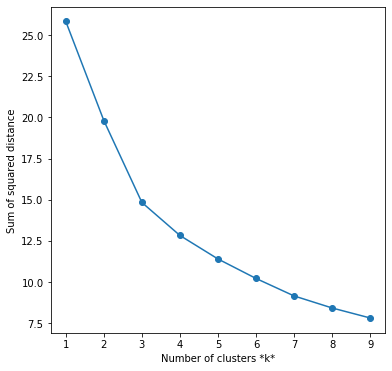

In [33]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [34]:
from sklearn.cluster import KMeans
#X = df_percent.to_numpy()
X = X_std
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X)

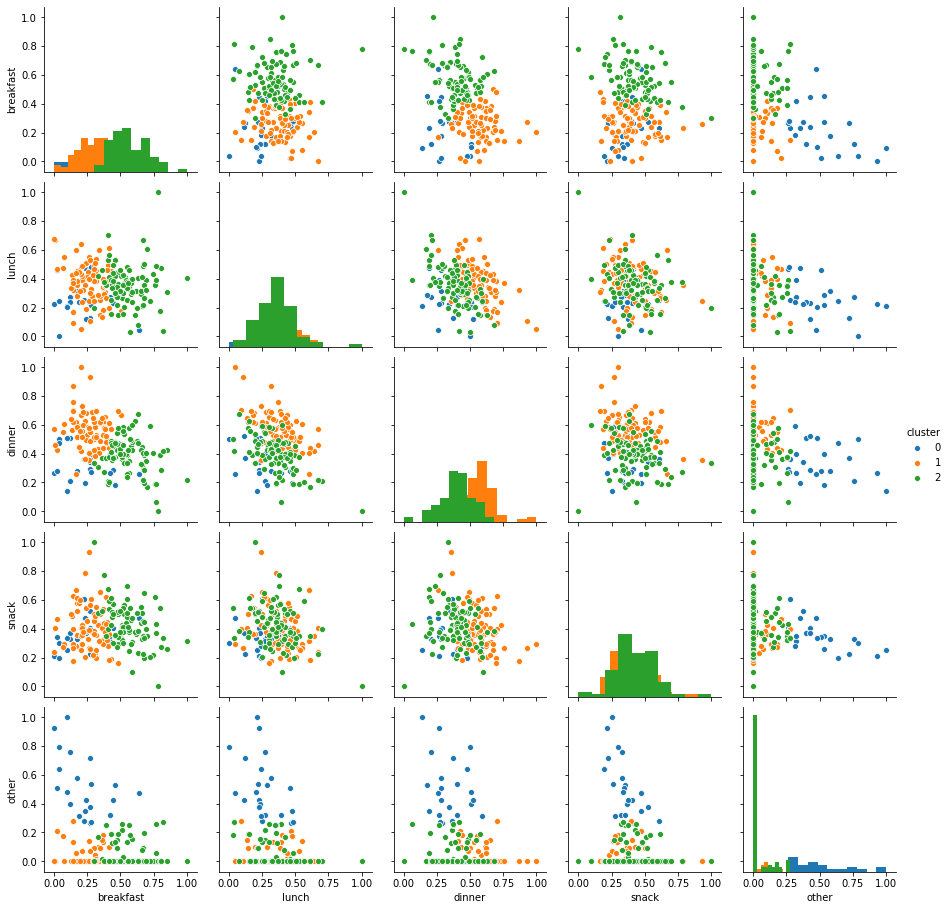

In [35]:
df_standard = pd.DataFrame(X_std,columns=['breakfast','lunch','dinner','snack','other'])
df_standard['cluster'] = y_km
sns.pairplot(df_standard,hue='cluster',diag_kind='hist')

## Analyze each cluster

In [36]:
group_0 = []
group_1 = []
group_2 = []
for i in range(0,188):
    if y_km[i] == 0:
        group_0.append(i)
    elif y_km[i] == 1:
        group_1.append(i)
    else:
        group_2.append(i)

In [37]:
df_percent['cluster'] = y_km

In [38]:
df_percent

,breakfast,lunch,dinner,snack,other,cluster
deidnum,,,,,,
1057,0.225325,0.283924,0.383114,0.107638,0.000000,2
1948,0.200221,0.264756,0.330676,0.126743,0.077605,2
2081,0.104624,0.265487,0.262471,0.098360,0.269059,0
2230,0.154902,0.326898,0.306527,0.152805,0.058868,2
2355,0.206369,0.322129,0.344280,0.127222,0.000000,2
...,...,...,...,...,...,...
98646,0.170256,0.262676,0.382600,0.184468,0.000000,1
98688,0.179520,0.216398,0.353016,0.183397,0.067669,2
99325,0.149555,0.363753,0.340292,0.146400,0.000000,1


In [39]:
df_0 = df_percent[df_percent['cluster']==0]
df_0.mean(axis = 0)

breakfast    0.131518
lunch        0.261016
dinner       0.322296
snack        0.105201
other        0.179969
cluster      0.000000
dtype: float64

In [40]:
df_1 = df_percent[df_percent['cluster']==1]
df_1.mean(axis=0)

breakfast    0.140009
lunch        0.309610
dinner       0.421551
snack        0.119150
other        0.009095
cluster      1.000000
dtype: float64

In [41]:
df_2 = df_percent[df_percent['cluster']==2]
df_2.mean(axis=0)

breakfast    0.213699
lunch        0.301369
dinner       0.343202
snack        0.127122
other        0.014609
cluster      2.000000
dtype: float64